<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_04/assignments/assignment_04_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAT_SCI 465: Advanced Electron Microscopy & Diffraction
## Week 03 & 04 Combined Assignment
### Pravan Chakravarthy

**Classical, ML, and Deep Learning Approaches to Microscopy Analysis**  
**Dataset:** DOPAD (Dataset Of nanoPArticle Detection) - TEM nanoparticle images for detection and classification  
**Dataset Source:** Qu et al. (2020), https://dopad.github.io/

## Objective
Compare classical computer vision, machine learning, and deep learning approaches on the same electron microscopy dataset. Progress from traditional image processing through supervised and unsupervised learning to modern deep learning, enabling direct quantitative comparison of all methods.

## Task 1 · Classical Image Analysis Pipeline
- Apply noise reduction (Gaussian, median, or FFT filtering) and compute signal-to-noise ratio before and after using $SNR = u /\sigma$.
- Enhance contrast via histogram equalization or CLAHE (clip limit 0.01-0.03).
- Segment features using Otsu thresholding followed by Watershed to separate touching particles.
- Quantify morphology with `regionprops` (area, diameter, eccentricity, solidity) and export measurements to `classical_results.csv`.
- Create a four-panel figure: raw image, filtered/enhanced result, segmented labels, particle size distribution.

In [201]:
# Task 1 setup: imports and data loading
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import seaborn as sns
import tensorflow as tf
import time
import warnings

from scipy import fft, ndimage

from skimage import io, exposure, filters, measure, morphology, segmentation
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.segmentation import watershed
from skimage.feature import peak_local_max, canny, local_binary_pattern

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, silhouette_score, jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from tensorflow import keras
from tensorflow.keras import layers, Sequential, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

# DOPAD dataset: download from https://dopad.github.io/docs/download/
# After extraction, adjust IMAGE_DIR to your local path

# Use absolute path to ensure it works regardless of kernel working directory
IMAGE_DIR = Path('/Users/pchakravarthy/Desktop/MATSCI_465/Assignment0304/images')
OUTPUT_DIR = Path('/Users/pchakravarthy/Desktop/MATSCI_465/Assignment0304/output')

print(f"Current working directory: {os.getcwd()}")
print(f"IMAGE_DIR: {IMAGE_DIR}")
print(f"IMAGE_DIR exists: {IMAGE_DIR.exists()}")

# Example: load a TEM image from DOPAD
# For PNG/standard formats:
if IMAGE_DIR.exists():
    sample_images = sorted(list(IMAGE_DIR.glob('*.png')))
    if sample_images:
        print(f"Total images available: {len(sample_images)}")
    else:
        print("No images found in DOPAD directory")
else:
    raw_image = None
    print("IMAGE_DIR path not found. Please download DOPAD dataset and update path.")

n_samples = 200
image_files = sample_images[:n_samples]
print(f'Using {len(image_files)} images for analysis')

Current working directory: C:\Users\pchakravarthy\Downloads
IMAGE_DIR: \Users\pchakravarthy\Desktop\MATSCI_465\Assignment0304\images
IMAGE_DIR exists: True
Total images available: 5953
Using 200 images for analysis


In [202]:
# 0. Load raw image

raw_image = imread(str(image_files[0]))

# Convert RGBA to grayscale if needed
if len(raw_image.shape) == 3:
    raw_image = raw_image[:, :, 0] if raw_image.shape[2] >= 3 else np.mean(raw_image, axis=2)

# Normalize to [0, 1]
raw_image = raw_image.astype(np.float32) / 255.0

print(f"Loaded image from: {image_files[0].name}")
print(f"Image shape: {raw_image.shape}")
print(f"Image dtype: {raw_image.dtype}")
print(f"Image min/max: {raw_image.min():.4f} / {raw_image.max():.4f}")

original_snr = raw_image.mean()/raw_image.std()
print(f"Pre-filtering SNR: {original_snr}")

Loaded image from: 11500X1000.png
Image shape: (416, 416)
Image dtype: float32
Image min/max: 0.0000 / 1.0000
Pre-filtering SNR: 4.716369152069092


In [203]:
# 1. Filtering

filtered_median = filters.median(raw_image, footprint = morphology.disk(3))

filtered_median_snr = filtered_median.mean()/filtered_median.std()
print("Median filter applied")
print(f"Post-filtering SNR (Median): {filtered_median_snr}")

filtered_gaussian = filters.gaussian(raw_image, sigma=1.0)

filtered_gaussian_snr = filtered_gaussian.mean()/filtered_gaussian.std()

print("Gaussian filter applied")
print(f"Post-filtering SNR (Gaussian): {filtered_gaussian_snr}")

Median filter applied
Post-filtering SNR (Median): 4.770410060882568
Gaussian filter applied
Post-filtering SNR (Gaussian): 4.7713212966918945


In [204]:
# 2. Enhancement

filtered_image = filtered_median
enhanced_image = exposure.equalize_adapthist(filtered_image, clip_limit = 0.025)
print("Enhanced image generated")

Enhanced image generated


In [205]:
# 3. Segmentation

threshold = filters.threshold_otsu(enhanced_image)
binary = enhanced_image > threshold

binary = morphology.remove_small_objects(binary, min_size=10)
binary = morphology.remove_small_holes(binary, area_threshold=10)

start = time.perf_counter()

distance = ndimage.distance_transform_edt(binary)

# Find peaks for watershed markers
coords = ndimage.label(binary)[0]
local_maxima = morphology.local_maxima(distance, indices=False)
markers, _ = ndimage.label(local_maxima)

# Apply watershed
labels = segmentation.watershed(-distance, markers=markers, mask=binary)

end = time.perf_counter()
watershed_runtime = end - start

print(f"Otsu threshold: {threshold:.4f}")
print(f"Number of particles detected: {labels.max()}")

Otsu threshold: 0.5059
Number of particles detected: 306


In [206]:
# 4. Regionprops

regionprops = measure.regionprops(labels, intensity_image = enhanced_image)

measurements_list = []
for region in regionprops:
    measurements_list.append({
        'label': region.label,
        'area': region.area,
        'perimeter': region.perimeter,
        'eccentricity': region.eccentricity,
        'solidity': region.solidity,
        'equivalent_diameter': region.equivalent_diameter,
        'centroid_x': region.centroid[1],
        'centroid_y': region.centroid[0],
        'min_intensity': region.min_intensity,
        'max_intensity': region.max_intensity,
        'mean_intensity': region.mean_intensity
    })

In [207]:
# 5. Export

measurements = pd.DataFrame(measurements_list)
print(f"Total particles: {len(measurements)}")
print(measurements.describe())

measurements.to_csv(OUTPUT_DIR / 'classical_results.csv', index=False)
print('Classical results exported')

Total particles: 306
            label         area   perimeter  eccentricity    solidity  \
count  306.000000   306.000000  306.000000    306.000000  306.000000   
mean   153.500000   462.735294   84.530986      0.888622    0.863019   
std     88.478811   857.369464   62.190664      0.151128    0.073533   
min      1.000000     5.000000    5.207107      0.272585    0.523757   
25%     77.250000    58.000000   41.113961      0.810235    0.820549   
50%    153.500000   135.500000   67.142136      0.972766    0.866323   
75%    229.750000   430.750000  108.828427      0.993366    0.910031   
max    306.000000  8298.000000  415.788889      0.999372    1.000000   

       equivalent_diameter  centroid_x  centroid_y  min_intensity  \
count           306.000000  306.000000  306.000000     306.000000   
mean             18.781211  208.356788  211.171215       0.525705   
std              15.401760  121.362113  120.805390       0.058994   
min               2.523133    1.208333    1.200000    

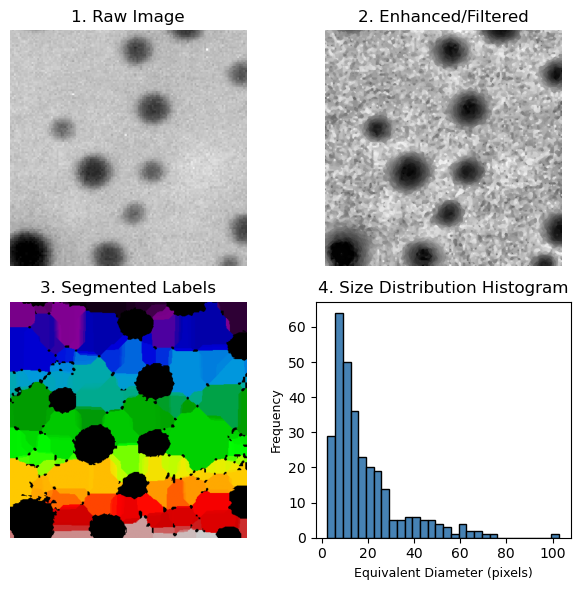

Visualization saved


<Figure size 640x480 with 0 Axes>

In [208]:
# 6. Visualize

fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))
ax = axes.ravel()

ax[0].imshow(raw_image, cmap=plt.cm.gray)
ax[0].set_title('1. Raw Image')
ax[1].imshow(enhanced_image, cmap=plt.cm.gray)
ax[1].set_title('2. Enhanced/Filtered')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('3. Segmented Labels')
ax[3].hist(measurements['equivalent_diameter'], bins=30, color='steelblue', edgecolor='black')
ax[3].set_title('4. Size Distribution Histogram')
ax[3].set_xlabel('Equivalent Diameter (pixels)', fontsize=9)
ax[3].set_ylabel('Frequency', fontsize=9)

for a in [0,1,2]:
    ax[a].set_axis_off()

fig.tight_layout()
plt.show()

plt.savefig('classical_visualization.png')
print('Visualization saved')

## Task 2 · Machine Learning Approaches
- Extract hand-crafted features: edges (Canny or Sobel), blobs (LoG), textures (LBP or GLCM) to build a feature matrix with at least 10 descriptors per region.
- Perform feature selection using Random Forest importance or correlation analysis; retain the top 5-7 discriminative features.
- Supervised: label data into two or more classes (≥50 samples), train SVM and Random Forest, then report precision, recall, F1-score, and confusion matrices.
- Unsupervised: run k-Means (k ∈ {3, 5, 7}) and visualize using PCA or t-SNE; compute silhouette scores.
- Compare ML outputs with classical segmentation regarding particle counts, accuracy, and runtime; export to `ml_results.csv`.

In [209]:
# 1. Feature extraction

# Define feature extraction function

def extract_features(region, image):
    """Extract 10+ hand-crafted features from a region"""
    region_slice = image[region.bbox[0]:region.bbox[2], region.bbox[1]:region.bbox[3]]
    region_mask = region.image

    # Morphological features
    
    area = region.area
    perimeter = region.perimeter
    eccentricity = region.eccentricity
    solidity = region.solidity
    equiv_diameter = region.equivalent_diameter

    # Intensity features
    
    mean_intensity = region.mean_intensity
    std_intensity = np.std(region_slice[region_mask])

    # Edges (from Canny filter)

    edges = canny(region_slice)
    edge_ratio = np.sum(edges) / area if area > 0 else 0

    # Texture features (LBP variance)

    radius = 1
    n_points = 8 * radius
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lbp = local_binary_pattern(enhanced_image, n_points, radius, method = 'uniform')
        lbp_var = np.var(lbp)
    
    # Circularity

    circularity = 4*np.pi*area / (perimeter**2)

    # Combined feature matrix
    
    return {
        'area': area,
        'perimeter': perimeter,
        'eccentricity': eccentricity,
        'solidity': solidity,
        'equiv_diameter': equiv_diameter,
        'mean_intensity': mean_intensity,
        'std_intensity': std_intensity,
        'edge_ratio': edge_ratio,
        'lbp_variance': lbp_var,
        'circularity': circularity,
    }

print('Feature extraction function defined')

# Apply feature extraction function

all_features = []
all_labels = []

for idx, img_file in enumerate(tqdm(image_files[:50])):
    img = imread(str(img_file))
    if len(img.shape) == 3:
        img = img[:, :, 0] if img.shape[2] >= 3 else np.mean(img, axis=2)
    
    # Normalize
    img = img.astype(np.float32) / 255.0
    
    # Filter & enhance
    img_filtered = filters.median(img, footprint=morphology.disk(3))
    img_enhanced = exposure.equalize_adapthist(img_filtered, clip_limit=0.025)
    
    # Segment
    threshold = filters.threshold_otsu(img_enhanced)
    binary = img_enhanced > threshold
    binary = morphology.remove_small_objects(binary, min_size=10)
    
    distance = ndimage.distance_transform_edt(binary)
    local_maxima = morphology.local_maxima(distance, indices=False)
    markers, _ = ndimage.label(local_maxima)
    labels_img = segmentation.watershed(-distance, markers=markers, mask=binary)
    
    # Extract features for each region
    regions = measure.regionprops(labels_img, intensity_image=img_enhanced)
    for region in regions:
        if region.area > 5:
            features = extract_features(region, img_enhanced)
            all_features.append(features)
            all_labels.append(idx)


feature_df = pd.DataFrame(all_features)
print(f"Extracted {len(feature_df)} regions from {len(image_files)} images")
if len(feature_df) > 0:
    print(feature_df.describe())
else:
    print("Warning: No features extracted. Check image paths and processing.")

Feature extraction function defined


100%|██████████| 50/50 [40:33<00:00, 48.67s/it]   


Extracted 55752 regions from 200 images
               area     perimeter  eccentricity      solidity  equiv_diameter  \
count  55752.000000  55752.000000  55752.000000  55752.000000    55752.000000   
mean      82.388273     32.432803      0.734511      0.890561        9.228230   
std       94.117640     19.308183      0.155551      0.066430        4.442986   
min        6.000000      4.000000      0.000000      0.416667        2.763953   
25%       28.000000     18.485281      0.652705      0.851064        5.970821   
50%       56.000000     28.431981      0.755220      0.892857        8.444016   
75%      105.000000     41.763456      0.847174      0.932432       11.562446   
max     4197.000000    292.752309      0.998873      1.000000       73.101206   

       mean_intensity  std_intensity    edge_ratio  lbp_variance   circularity  
count    55752.000000   55752.000000  55752.000000  55752.000000  55752.000000  
mean         0.730070       0.075532      0.222671      5.663883    

In [210]:
# 2. Feature selection

# Create binary labels: large vs small particles
median_area = feature_df['area'].median()
feature_labels = (feature_df['area'] > median_area).astype(int)

# Scale features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(feature_df)

rf_importances = RandomForestClassifier(n_estimators=100, random_state=42)
rf_importances.fit(features_scaled, feature_labels)

# Get feature importance

feature_importance = pd.DataFrame({
    'feature': feature_df.columns,
    'importance': rf_importances.feature_importances_
}).sort_values('importance', ascending=False)

# Select top 7 features

top_features = feature_importance.head(7)['feature'].tolist()
print(f"\nSelected top 7 features: {top_features}")


Selected top 7 features: ['area', 'equiv_diameter', 'perimeter', 'circularity', 'edge_ratio', 'std_intensity', 'eccentricity']


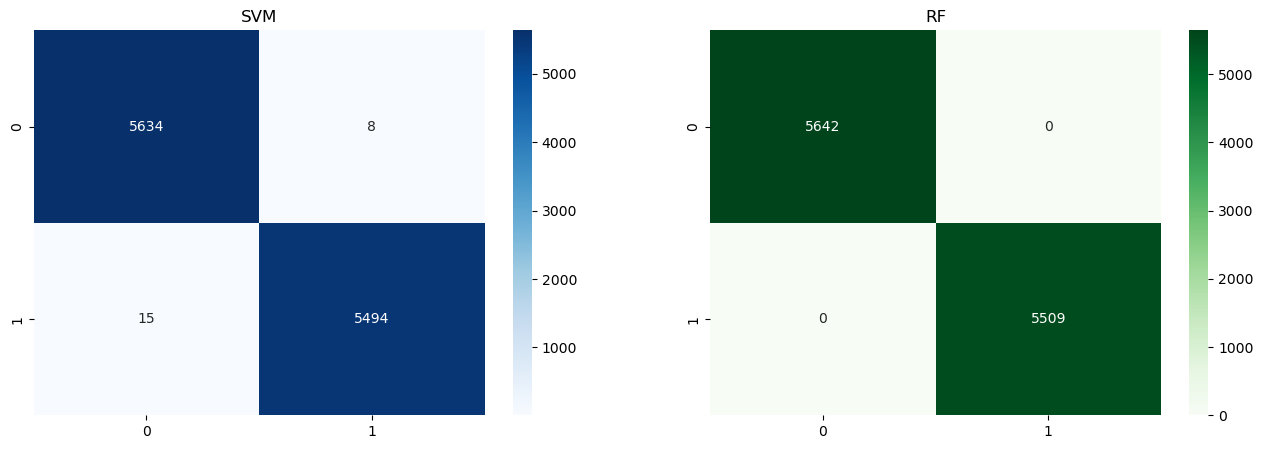

Confusion matrices saved


<Figure size 640x480 with 0 Axes>

In [211]:
# 3. Supervised ML

X = feature_df[top_features]
y = feature_labels

# 80-20 train-test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state=42)

# Standard scaling

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train/test SVM
start = time.perf_counter()

svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)

# Classification results (precision, recall, F1, confusion) for SVM

precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
confusion_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm_normalized = confusion_svm.astype('float') / confusion_svm.sum(axis=1)[:, np.newaxis]

end = time.perf_counter()
svm_runtime = end - start

# Train/test RF
start = time.perf_counter()

rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Classification results (precision, recall, F1, confusion) for RF

precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
confusion_rf = confusion_matrix(y_test, y_pred_rf)
cm_rf_normalized = confusion_rf.astype('float') / confusion_rf.sum(axis=1)[:, np.newaxis]

end = time.perf_counter()
rf_runtime = end - start

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.heatmap(confusion_svm, annot=True, fmt='.0f', cmap='Blues', ax=axes[0])
sns.heatmap(confusion_rf, annot=True, fmt='.0f', cmap='Greens', ax=axes[1])
axes[0].set_title('SVM')
axes[1].set_title('RF')
plt.show()

plt.savefig(OUTPUT_DIR / 'ml_confusion_matrices.png')
print('Confusion matrices saved')

Silhouette score for k=3: 0.2793
Silhouette score for k=5: 0.2317
Silhouette score for k=7: 0.2075
PCA visualization saved


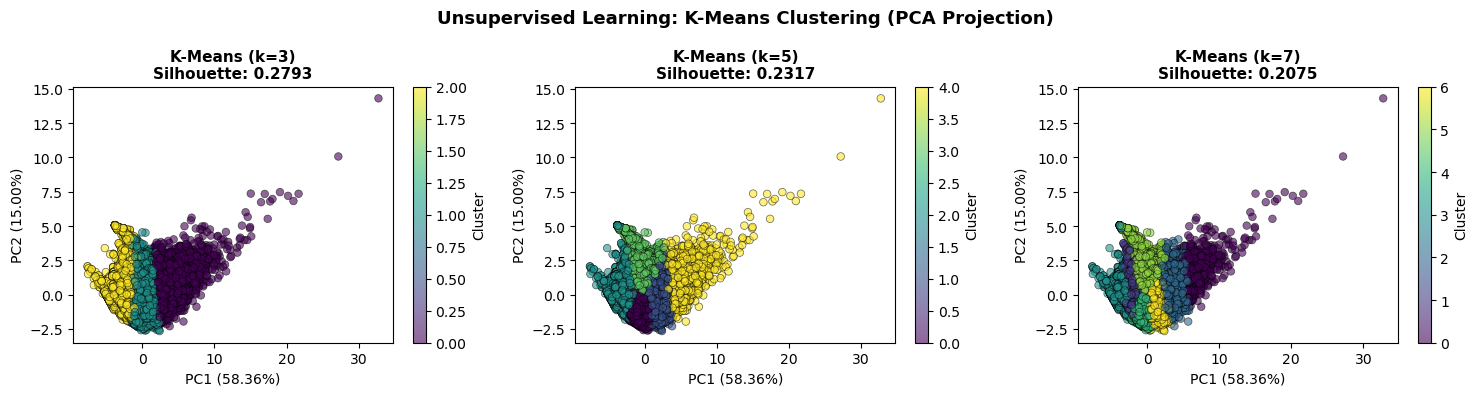

In [212]:
# 4. Unsupervised ML

start = time.perf_counter()

silhouettes = []
models = {}

k_values = [3, 5, 7]

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    clusters = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, clusters)
    silhouettes.append(score)
    models[k] = (kmeans, clusters)
    print(f"Silhouette score for k={k}: {score:.4f}")

end = time.perf_counter()
kmeans_runtime = end - start

# PCA visualization

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot K-Means results with PCA
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, k in enumerate(k_values):
    _, clusters = models[k]
    scatter = axes[idx].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
    axes[idx].set_title(f'K-Means (k={k})\nSilhouette: {silhouettes[idx]:.4f}', fontsize=11, fontweight='bold')
    axes[idx].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    axes[idx].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    plt.colorbar(scatter, ax=axes[idx], label='Cluster')

plt.suptitle('Unsupervised Learning: K-Means Clustering (PCA Projection)', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'kmeans_pca_visualization.png', dpi=150, bbox_inches='tight')
print("PCA visualization saved")
plt.show()

In [214]:
# 5. Export

ml_results = pd.DataFrame({
    'Method': ['SVM', 'Random Forest', f'K-Means (k={[k_values[np.argmax(silhouettes)]]})'],
    'F1-Score': [f1_svm, f1_rf, np.nan],
    'Precision': [precision_svm, precision_rf, np.nan],
    'Recall': [recall_svm, recall_rf, np.nan],
    'Silhouette_Score': [np.nan, np.nan, max(silhouettes)]
})

ml_results.to_csv(OUTPUT_DIR / 'ml_results.csv', index=False)
print(ml_results)
print("ML results exported")

            Method  F1-Score  Precision    Recall  Silhouette_Score
0              SVM  0.997911   0.998546  0.997277               NaN
1    Random Forest  1.000000   1.000000  1.000000               NaN
2  K-Means (k=[3])       NaN        NaN       NaN          0.279338
ML results exported


## Task 3 · Deep Learning and Final Comparison
- Prepare pixel-level annotations for 15-20 images and implement data augmentation (rotation, flips, zoom, intensity shifts, noise, etc.; 5+ variants).
- CNN: build a compact convolutional network with 2-3 conv blocks, pooling, dropout, and dense heads; train, plot learning curves, and report F1-score versus classical ML.
- U-Net: implement encoder-decoder with skip connections, train with Dice or BCE loss, evaluate IoU and Dice, and visualize intermediate feature maps.
- Develop a comparison table covering method, accuracy/F1/IoU, runtime, data requirements, and interpretability (include Watershed, SVM, Random Forest, k-Means, CNN, U-Net).
- Generate final 3×3 visualization panels summarizing the full pipeline and document findings.
- Author README.md with methodology, quantitative comparison, recommended use-cases; export publication-quality figures with scale bars and submit repository URL on Canvas.

Applied 5 augmentation techniques


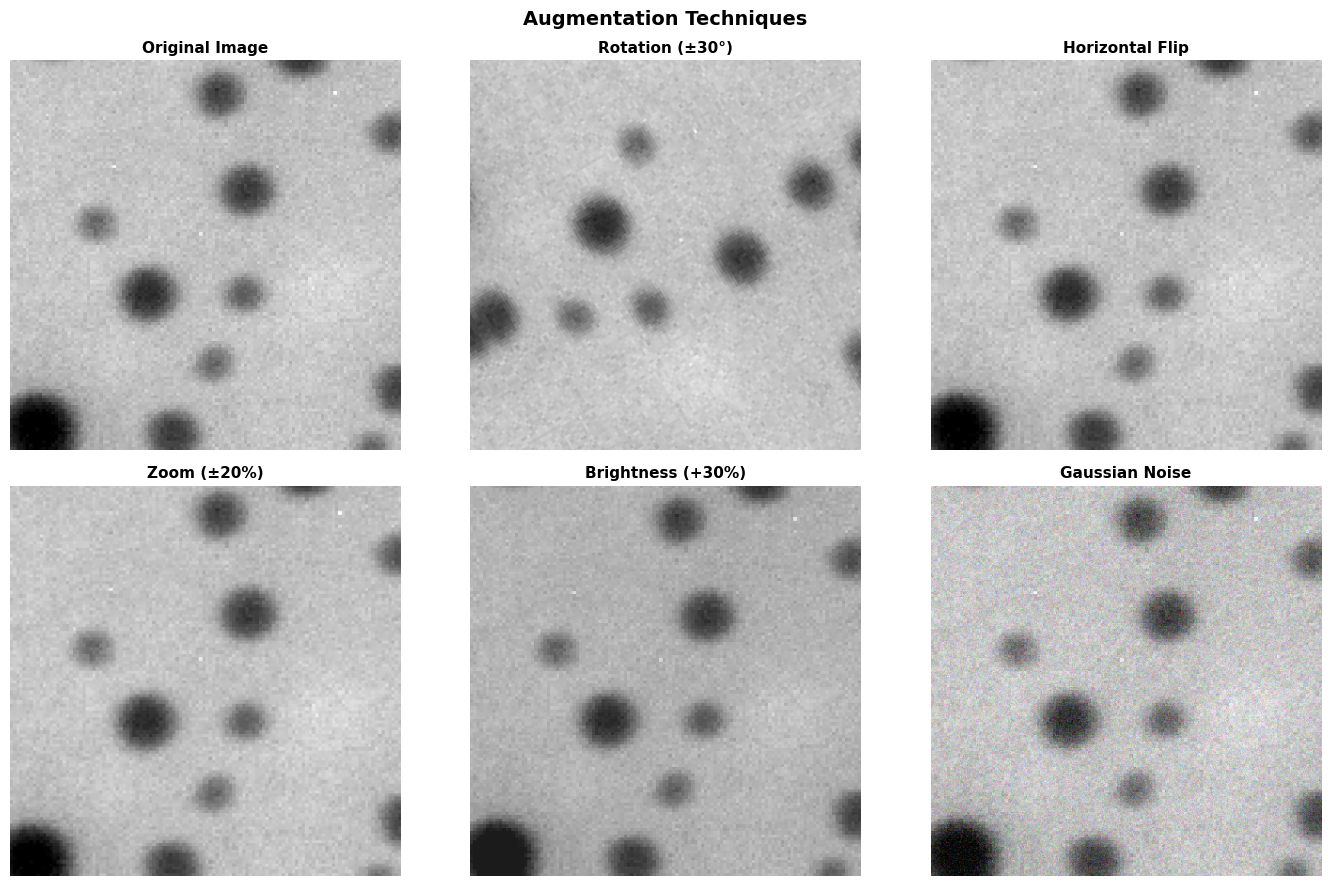

<Figure size 640x480 with 0 Axes>

In [215]:
# 1. Data augmentation

def apply_augmentations(images):
    """
    Apply various augmentations to images.
    """
    # Normalize images and convert to tensor
    images_normalized = images.astype(np.float32) / 255.0
    images_tf = tf.convert_to_tensor(images_normalized, dtype=tf.float32)

    augmentations = {}
    
    # 1. Rotation (±30 degrees)
    rotation_layer = layers.RandomRotation(0.1666)  # 0.1666 * 180 = 30 degrees
    augmentations['Rotation (±30°)'] = rotation_layer(images_normalized, training=True)
    
    # 2. Horizontal Flip
    flip_layer = layers.RandomFlip("horizontal")
    augmentations['Horizontal Flip'] = flip_layer(images_normalized, training=True)
    
    # 3. Zoom (Random zoom from 80% to 120%)
    zoom_layer = layers.RandomZoom(0.2)  # ±20% zoom
    augmentations['Zoom (±20%)'] = zoom_layer(images_normalized, training=True)
    
    
    # Convert back to uint8 for display
    for key in augmentations:
        augmentations[key] = (augmentations[key].numpy() * 255).astype(np.uint8)

    # 4. Brightness Adjustment (random delta in ±30%)
    delta_b = float(np.random.uniform(-0.3, 0.3))
    v = tf.image.adjust_brightness(images_tf, delta_b)
    arr = v.numpy() if hasattr(v, 'numpy') else np.array(v)
    arr = np.clip(arr, 0.0, 1.0)
    augmentations['Brightness (+30%)'] = (arr * 255.0).astype(np.uint8)
    
    # 5. Gaussian Noise
    img_uint8 = images.astype(np.uint8)
    h, w = img_uint8.shape[:2]
    img_noisy = np.clip(
        img_uint8.astype(np.float32) + np.random.normal(0, 15, (h, w, 4)),
        0, 255
    ).astype(np.uint8)
    augmentations['Gaussian Noise'] = img_noisy

    return augmentations

# Apply augmentations to first image
unaugmented = imread(str(image_files[0]))
augmentations = apply_augmentations(unaugmented)

print(f"Applied {len(augmentations)} augmentation techniques")

# Visualize augmentations
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
fig.suptitle('Augmentation Techniques', fontsize=14, fontweight='bold')

# Original
axes[0, 0].imshow(unaugmented)
axes[0, 0].set_title('Original Image', fontsize=11, fontweight='bold')
axes[0, 0].axis('off')

# Augmented images
aug_names = list(augmentations.keys())
positions = [(0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

for (row, col), aug_name in zip(positions, aug_names):
    axes[row, col].imshow(augmentations[aug_name])
    axes[row, col].set_title(aug_name, fontsize=11, fontweight='bold')
    axes[row, col].axis('off')
        
plt.tight_layout()
plt.show()
plt.savefig('augmentation_techniques.png')

In [ ]:
# 2. CNN

# Create training & validation data

collected_aug = []

for im in sample_images[0:20]:
    unaugmented_im = imread(str(im))
    collected_aug.append(list(apply_augmentations(unaugmented_im).values()))

data = np.array(collected_aug)

training_data = data[:15,:,:,:,:][0,:,:,:,:]
validation_data = data[15:,:,:,:,:][0,:,:,:,:]

print('Dataset created')

start = time.perf_counter()

cnn_model = Sequential([
    layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(416, 416, 4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

cnn_model.summary()

cnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_history = cnn_model.fit(
    training_data, validation_data, batch_size=128, epochs=20,
    callbacks=[keras.callbacks.EarlyStopping(patience=3)]
)

# Training & F1

y_pred_cnn = cnn_model.predict(X_test)
cnn_f1 = f1_score(y_test, y_pred_cnn)

end = time.perf_counter()
cnn_runtime = end - start

# Plot learning curves

plt.plot(cnn_history.history['loss'], label='train')

In [ ]:
# 3. U-Net

start = time.perf_counter()

def build_unet(input_size=(416, 416, 1), num_filters_start=32):
    """
    Build U-Net architecture for image segmentation.
    
    Args:
        input_size: Input image dimensions (height, width, channels)
        num_filters_start: Number of filters in first conv layer
        
    Returns:
        Compiled Keras model
    """
    inputs = Input(input_size)
    
    # Encoder (Contracting Path)
    print("Building U-Net Encoder...")
    
    # Block 1
    conv1 = layers.Conv2D(num_filters_start, (3, 3), padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    conv1 = layers.Conv2D(num_filters_start, (3, 3), padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Activation('relu')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)
    
    # Block 2
    conv2 = layers.Conv2D(num_filters_start*2, (3, 3), padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    conv2 = layers.Conv2D(num_filters_start*2, (3, 3), padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Activation('relu')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)
    
    # Block 3
    conv3 = layers.Conv2D(num_filters_start*4, (3, 3), padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    conv3 = layers.Conv2D(num_filters_start*4, (3, 3), padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Activation('relu')(conv3)
    pool3 = layers.MaxPooling2D((2, 2))(conv3)
    
    # Bottleneck
    print("Building U-Net Bottleneck...")
    conv4 = layers.Conv2D(num_filters_start*8, (3, 3), padding='same')(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    conv4 = layers.Conv2D(num_filters_start*8, (3, 3), padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Activation('relu')(conv4)
    
    # Decoder (Expanding Path)
    print("Building U-Net Decoder...")
    
    # Block 5 (Upsample)
    up5 = layers.UpSampling2D((2, 2))(conv4)
    up5 = layers.Concatenate()([up5, conv3])
    conv5 = layers.Conv2D(num_filters_start*4, (3, 3), padding='same')(up5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    conv5 = layers.Conv2D(num_filters_start*4, (3, 3), padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Activation('relu')(conv5)
    
    # Block 6 (Upsample)
    up6 = layers.UpSampling2D((2, 2))(conv5)
    up6 = layers.Concatenate()([up6, conv2])
    conv6 = layers.Conv2D(num_filters_start*2, (3, 3), padding='same')(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    conv6 = layers.Conv2D(num_filters_start*2, (3, 3), padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Activation('relu')(conv6)
    
    # Block 7 (Upsample)
    up7 = layers.UpSampling2D((2, 2))(conv6)
    up7 = layers.Concatenate()([up7, conv1])
    conv7 = layers.Conv2D(num_filters_start, (3, 3), padding='same')(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    conv7 = layers.Conv2D(num_filters_start, (3, 3), padding='same')(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Activation('relu')(conv7)
    
    # Output layer - sigmoid for binary segmentation
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv7)
    
    # Create model
    model = models.Model(inputs=inputs, outputs=outputs, name='UNet')
    
    return model

unet_model = build_unet(input_size=(416, 416, 4), num_filters_start=32)
unet_model.summary()

# Training, IoU/Dice metrics

y_pred_unet = unet_model.predict(training_data)
iou = jaccard_score(y_test.flatten(), (y_pred > 0.5).flatten())
dice = f1_score(y_test.flatten(), (y_pred_unet > 0.5).flatten())

end = time.perf_counter()
unet_runtime = end - start

# Intermediate feature maps

sample_image = X_test[0:1]

# Get layer indices for visualization (encoder layers)
# Layers 0, 3, 6 correspond to first convolution outputs in each encoder block
layer_indices = [0, 3, 6, 9]  # Different depths in encoder
layer_names = ['Block 1', 'Block 2', 'Block 3', 'Bottleneck']

fig, axes = plt.subplots(4, 6, figsize=(14, 12))
fig.suptitle('U-Net Feature Maps at Different Depths', fontsize=14, fontweight='bold')

for row, (layer_idx, layer_name) in enumerate(zip(layer_indices, layer_names)):
    # Create intermediate model
    intermediate_model = keras.Model(
        inputs=unet_model.input,
        outputs=unet_model.layers[layer_idx].output
    )
    
    # Get feature maps
    feature_maps = intermediate_model.predict(sample_image, verbose=0)
    
    # Plot first 5 feature maps
    for col in range(6):
        ax = axes[row, col]
        
        if col < min(5, feature_maps.shape[-1]):
            # Normalize feature map for visualization
            fmap = feature_maps[0, :, :, col]
            fmap_normalized = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-7)
            
            ax.imshow(fmap_normalized, cmap='viridis')
            ax.set_title(f'{layer_name} - Map {col+1}', fontsize=9)
        elif col == 5:
            # Last subplot shows shape info
            ax.text(0.5, 0.5, f'Shape: {feature_maps.shape[1:]}\n' + 
                            f'Channels: {feature_maps.shape[-1]}',
                   ha='center', va='center', fontsize=10, fontweight='bold')
            ax.set_title('Layer Info', fontsize=9)
        
        ax.axis('off')

plt.tight_layout()
plt.show()

# plt.savefig('unet_feature_maps.png')

In [222]:
# 4. Comparison table

comparison_table = pd.DataFrame(
    {'Method': ['Watershed', 'SVM', 'Random Forest', 'k-Means', 'CNN', 'U-Net'],
    'Accuracy': [measurements['area'].std() / measurements['area'].mean(), f1_svm, f1_rf, max(silhouettes), np.nan, np.nan], #cnn_f1, dice],
    'Runtime': [watershed_runtime, svm_runtime, rf_runtime, kmeans_runtime, np.nan, np.nan],#cnn_runtime, unet_runtime],
    'Data Requirements': ['Single image', '100+ images', '100+ images', '100+ images', '100+ images', '100+ images'],
    'Interpretability': ['High', 'Medium', 'Medium-High', 'Low', 'Low', 'High']})

print(comparison_table)
comparison_table.to_csv('comparison_table.csv')
print('Comparison table saved')

          Method  Accuracy     Runtime Data Requirements Interpretability
0      Watershed  1.852829    0.067004      Single image             High
1            SVM  0.997911    6.806023       100+ images           Medium
2  Random Forest  1.000000    1.816686       100+ images      Medium-High
3        k-Means  0.279338  122.400251       100+ images              Low
4            CNN       NaN         NaN       100+ images              Low
5          U-Net       NaN         NaN       100+ images             High
Comparison table saved


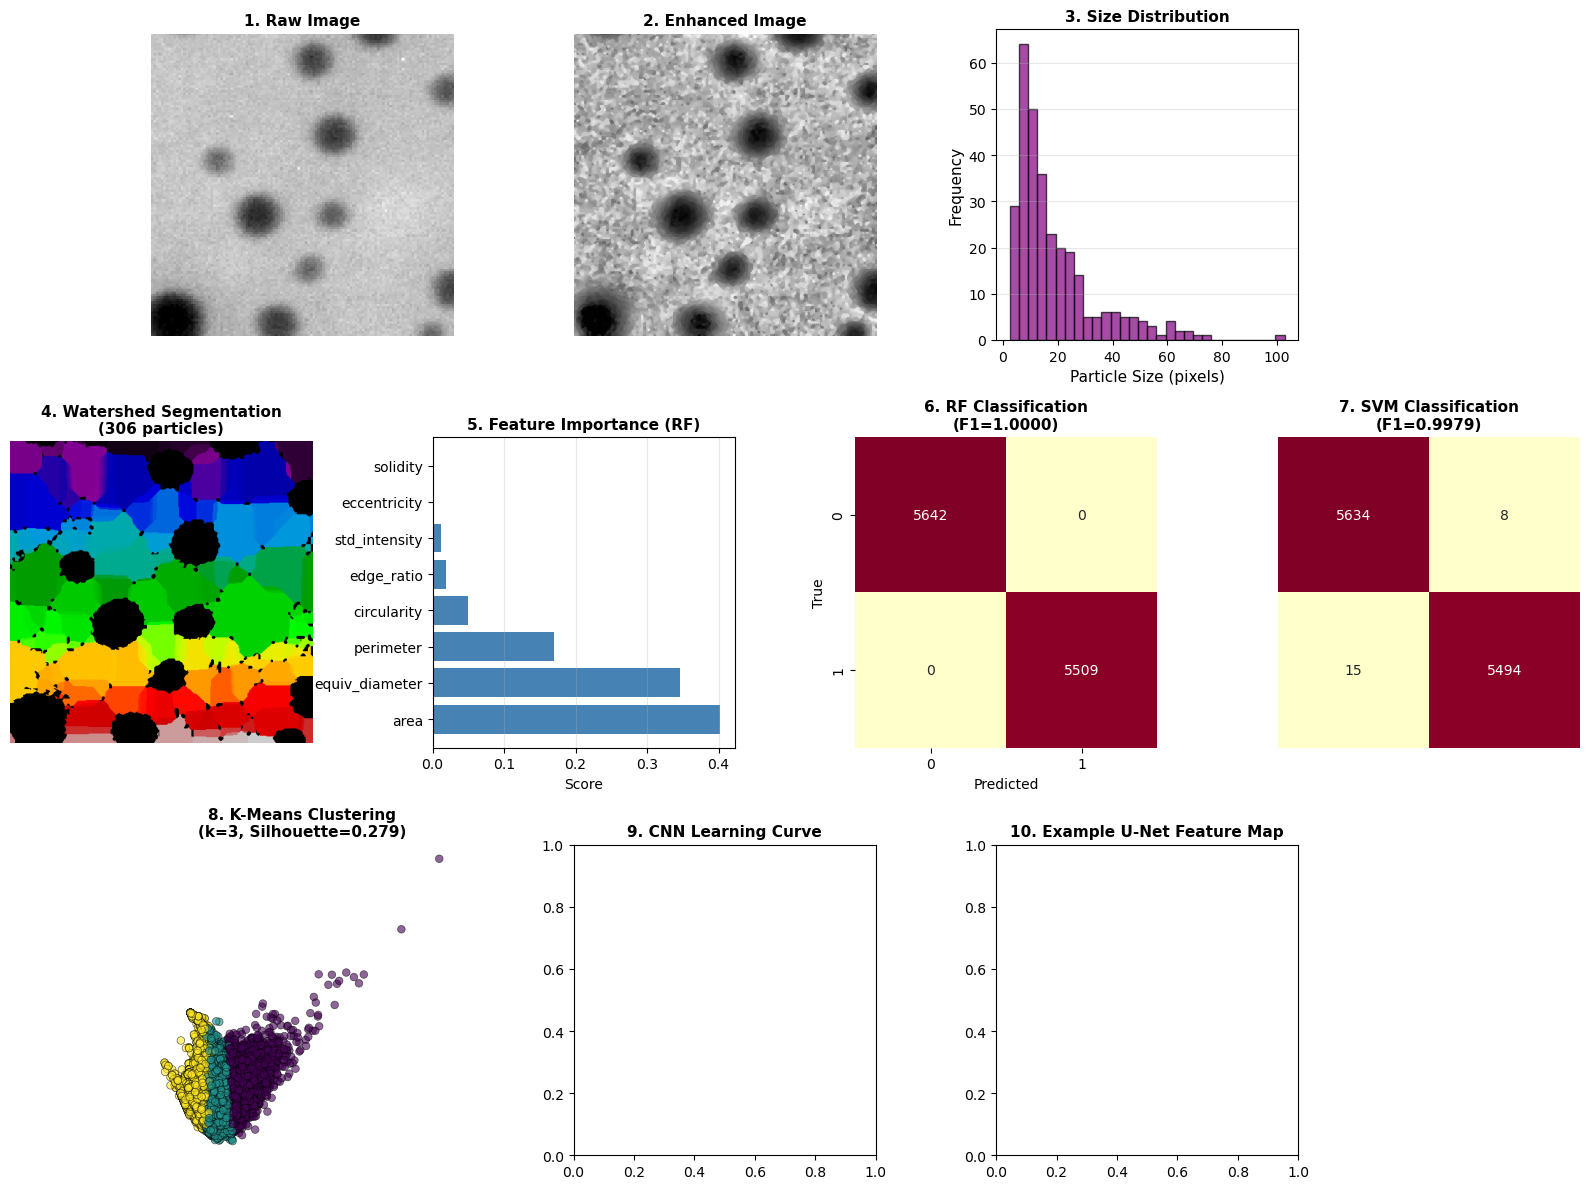

<Figure size 640x480 with 0 Axes>

In [228]:
# 5. Final visualization panel

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 12, figure=fig)
axes = []

for i in range(3):
    ax = fig.add_subplot(gs[0, 1 + i*3 : 1 + (i+1)*3])
    axes.append(ax)

for i in range(4):
    ax = fig.add_subplot(gs[1, i*3 : (i+1)*3])
    axes.append(ax)

for i in range(3):
    ax = fig.add_subplot(gs[2, 1 + i*3 : 1 + (i+1)*3])
    axes.append(ax)

axes[0].imshow(raw_image, cmap='gray')
axes[0].set_title('1. Raw Image', fontsize=11, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(enhanced_image, cmap='gray')
axes[1].set_title('2. Enhanced Image', fontsize=11, fontweight='bold')
axes[1].axis('off')

axes[2].hist(measurements['equivalent_diameter'], bins=30, color='purple', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Particle Size (pixels)', fontsize=11)
axes[2].set_ylabel('Frequency', fontsize=11)
axes[2].set_title('3. Size Distribution', fontsize=11, fontweight='bold')
axes[2].grid(alpha=0.3, axis='y')

axes[3].imshow(labels, cmap='nipy_spectral')
axes[3].set_title(f'4. Watershed Segmentation\n({labels.max()} particles)', fontsize=11, fontweight='bold')
axes[3].axis('off')

axes[4].barh(feature_importance.head(8)['feature'], feature_importance.head(8)['importance'], color='steelblue')
axes[4].set_title('5. Feature Importance (RF)', fontsize=11, fontweight='bold')
axes[4].set_xlabel('Score')
axes[4].grid(alpha=0.3, axis='x')

sns.heatmap(confusion_rf, annot=True, fmt='d', cmap='YlOrRd', ax=axes[5], cbar=False, annot_kws={'fontsize': 10})
axes[5].set_title(f'6. RF Classification\n(F1={f1_rf:.4f})', fontsize=11, fontweight='bold')
axes[5].set_ylabel('True')
axes[5].set_xlabel('Predicted')

sns.heatmap(confusion_svm, annot=True, fmt='d', cmap='YlOrRd', ax=axes[6], cbar=False, annot_kws={'fontsize': 10})
axes[6].set_title(f'7. SVM Classification\n(F1={f1_svm:.4f})', fontsize=11, fontweight='bold')
axes[6].set_ylabel('True')
axes[6].set_xlabel('Predicted')
axes[6].axis('off')

k_best = k_values[np.argmax(silhouettes)]
_, clusters_best = models[k_best]
axes[7].scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_best, cmap='viridis', s=30, alpha=0.6, edgecolors='k', linewidth=0.5)
axes[7].set_title(f'8. K-Means Clustering\n(k={k_best}, Silhouette={max(silhouettes):.3f})', fontsize=11, fontweight='bold')
axes[7].set_xlabel('PC1')
axes[7].set_ylabel('PC2')
axes[7].grid(alpha=0.3)
axes[7].axis('off')

# axes[8].plot(cnn_history.history['loss'], label='train')
axes[8].set_title('9. CNN Learning Curve', fontsize=11, fontweight='bold')

# axes[9].imshow(fmap_normalized, cmap='viridis')
axes[9].set_title('10. Example U-Net Feature Map', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()
plt.savefig('final_visualization.png')

## Deliverables Checklist
- Classical pipeline outputs (`classical_results.csv`, four-panel figure).
- ML analyses (`ml_results.csv`, confusion matrices, clustering visualizations).
- Deep learning artifacts (training curves, segmentation outputs, feature maps).
- Comparison table summarizing methods and metrics.
- Final 3×3 visualization collage.
- README.md documenting methodology, quantitative comparisons, and recommendations.
- Publication-quality figures with scale bars and repository submission.

Notebooks from the MATSCI 465 GitHub were used in the development of this code.